In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import (
    mean_squared_error,
    explained_variance_score,
    mean_absolute_error,
    r2_score,
)
from sklearn.preprocessing import MinMaxScaler
import pickle
import matplotlib.pyplot as plt
from incremental_trees.models.regression.streaming_rfr import StreamingRFR


In [12]:
def randomForestRegressor(X, y):
    
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.05, random_state=42
    )

    # n = y.shape[0]
    # lim = 15
    # X_train, X_test, y_train, y_test = X.iloc[:n-lim], X.iloc[n-lim:], y.iloc[:n-lim], y.iloc[n-lim:]
    regr = RandomForestRegressor(
        n_estimators=100,
        criterion="mse",
        max_depth=100,
        min_samples_leaf=2,
        bootstrap=True,
        warm_start=False,
    )
    print(f"Entrenando {y.name}")
    regr.fit(X_train, y_train)
    predicts = regr.predict(X_test)

    # print("Parameters:", regr.get_params())
    # print("Mean Absolute Error:", mean_absolute_error(y_test, predicts))
    print("Mean Squared Error:", mean_squared_error(y_test, predicts))
    # print("Root Mean Squared Error:", np.sqrt(mean_squared_error(y_test, predicts)))
    # print("Mean Absolute Percentage Error:", np.mean(np.abs((y_test, predicts)) * 100))
    print("R2:", regr.score(X_test, y_test))  # , r2_score(y_test, predicts))

    return regr, regr.predict(X)

In [3]:
def fit_rf_i(df, pkl_file):
    X = df[
        [
            "expuestos_t_6", "expuestos_t_7", "decesos_t_5", "decesos_t_6"
        ]
    ]
    y = df["infectados"]
    model, y_predict = randomForestRegressor(X, y)
    pickle.dump(model, open(pkl_file, 'wb'))

    df["infectados_predicho"] = pd.Series(y_predict)
    return df, model

## Entrenar modelo con los datos hasta Julio

In [13]:
# Leer datos
data = "./data/seird_constantes_dia_colombia_dependencia_cruzada_emulador.csv"
df_1 = pd.read_csv(data)
df = df_1.drop(columns=['fecha'])

# Normalizar datos
scaler = MinMaxScaler()
scaled_values = scaler.fit_transform(df)
df.loc[:,:] = scaled_values
df['fecha'] = df_1['fecha']

# Entrenar modelo con los datos hasta Julio
df_julio = df
df_julio, model = fit_rf_i(df_julio, "./pkl/i_col_emulador.pkl")
df_julio[["fecha", "infectados", "infectados_predicho"]]

Entrenando infectados
Mean Squared Error: 0.005022712426239107
R2: 0.9219647094817275


,fecha,infectados,infectados_predicho
0,2020-03-13,0.000000,0.000638
1,2020-03-14,0.000996,0.000822
2,2020-03-15,0.000843,0.000800
3,2020-03-16,0.000690,0.000745
4,2020-03-17,0.001532,0.001242
...,...,...,...
184,2020-09-13,0.558501,0.431485
185,2020-09-14,0.423722,0.433712
186,2020-09-15,0.499808,0.529016
187,2020-09-16,0.590146,0.562658


## Comparando datos reales vs datos predichos hasta julio

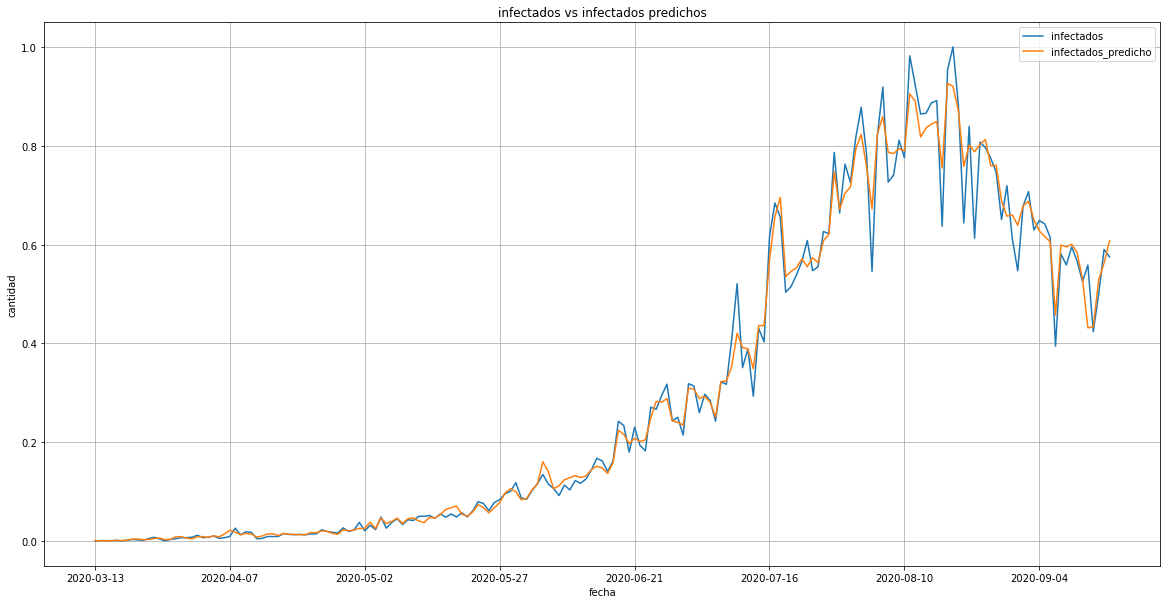

In [14]:
df_julio.plot(
    x="fecha",
    y=["infectados", "infectados_predicho"],
    kind="line",
    figsize=(20, 10),
    grid=True,
    legend=True,
    loglog=False,
    title="infectados vs infectados predichos",
)
plt.ylabel("cantidad")
plt.show()